# Measuring Cultural Influence Through Architectural Styles
by Yuval Yaffe and Michael Lellouch

## Project Idea and Goals
Along with the story of civilization, architecture has been one of the expressions of culture. Dictated by geography, available materials, usage and aesthetic style, the differences between all cultures is clearly manifested through architecture. <br/>
These differences are apparent even to the untrained eye. For example, although we've never seen these buildings below before we know the geographical area they are found in, and the cultural background that affected the designer. <br />
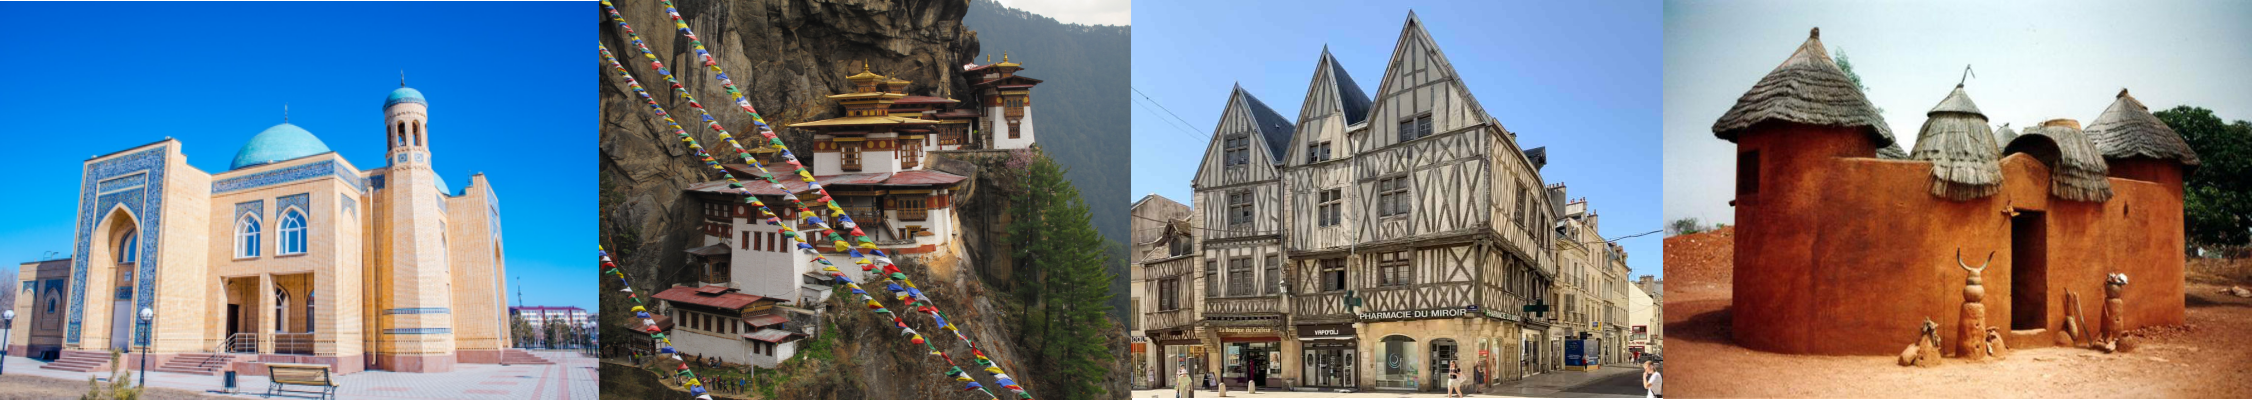 <br />

Like culture, architectural styles have influenced each other and have created new ideas and styles. Again, this is something we can easily notice. Although the images below are of buildings that are seprated between ~2000 years and 7000km, the influence is uncanny.<br/>

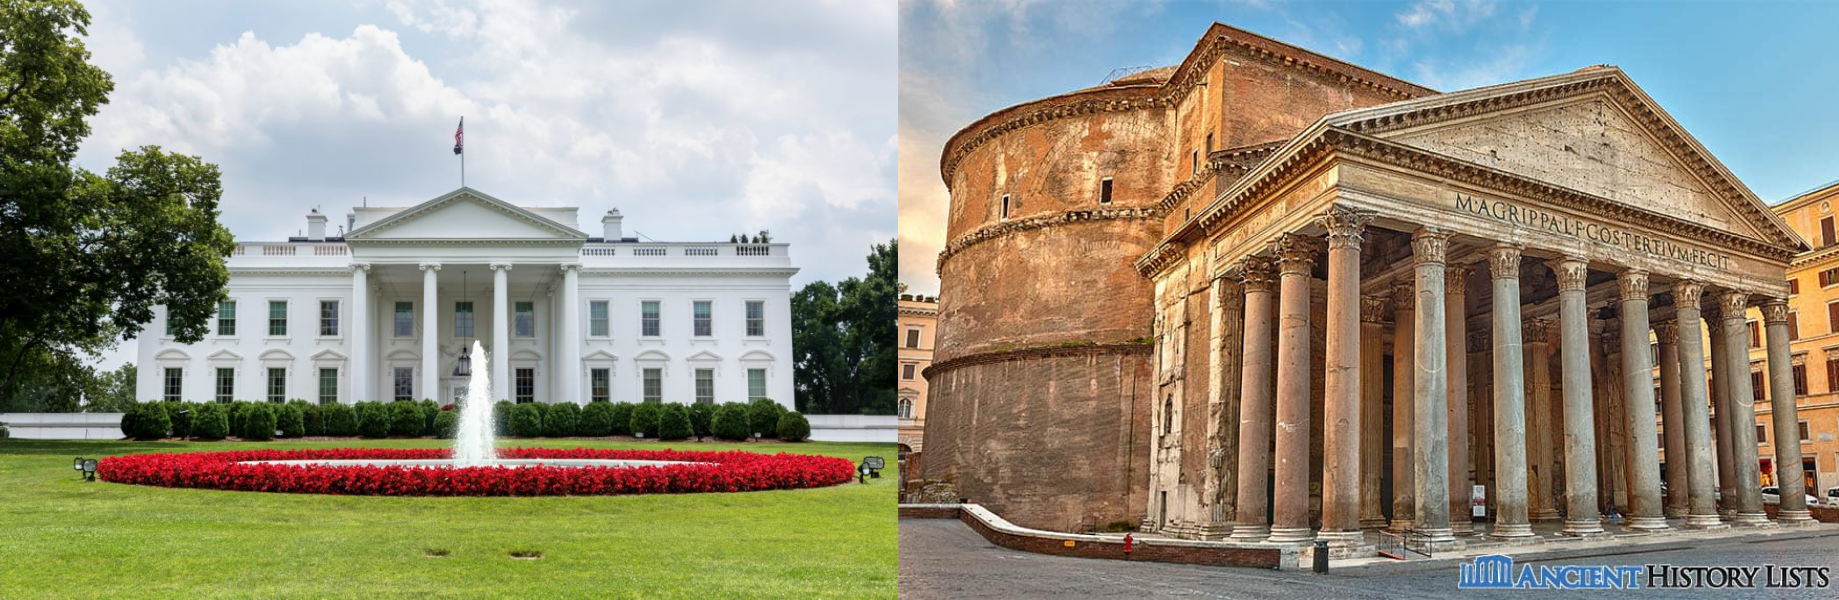

<br />
The goal of this project is to measure this effect and find new relations that are beyond common knowledge.<br> Our plan is that through the processing and classification of thousands of images of buildings and structures, we'll be able to discover this information.<br/>

### Outputs
Since our data is geographical in its nature, the core output we want to achieve are maps. The most important map we want to create is a map showing the different architectural styles that were found. <br>
Onces this information is gathered and processed, we'll be able to create more "meta-data" maps, e.g:
*  Finding the center of mass each style<br>

Moreover, we'll be able to use our results with statistical methods:
* Finding which styles are correlated - i.e. which styles appear together.
* Which styles are not correlated with any other style - i.e. which styles appeared in "their own bubble"


### Assessing our Outputs
We'll be able to asses our output in a supervised paradigm and an unsupervised paradigm. Firstly, to test our output in a supervised manner we'll compare it against common knowledge facts. For example, we can see if the data suggests the following:<br>
1. The medieval architectural styles that were clustered around Europe.
2. The presence and effects of the Muslim religion from the middle east to north Africa and up to Spain.
3. The revival of Greek architecture during the Renaissance in Europe. 
4. The European influence on the new world. 

And on the contrary, to test our results in an unsupervised manner we'll see if we can find conclusions that were not known in advance. These conclusions not possible to predict  by definition.<br>

# The Data
From the goals stated above, we have two tasks at hand:
## 1. Training an Architectural Style classifier
Our first step is being able to classify different styles. To do so, we have defined the styles we wish to classify. The decision of which styles are going to be classified was based on premilanry research.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import colors
import visualization
import matplotlib.pyplot as plt
data = pd.read_csv('../data/architectural_styles.csv')
data.head(10)

/home/MAGICLEAP/mlellouch/.pyenv/versions/3.6.5/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


id          class    subclass subclass2  start year  \
0  1.0  ancient greek         NaN       NaN      -900.0   
1  2.0  ancient india         NaN       NaN      -800.0   
2  NaN            NaN         NaN       NaN         NaN   
3  3.0          roman         NaN       NaN      -500.0   
4  4.0      byzantine         NaN       NaN       330.0   
5  5.0        islamic      mamluk       NaN      1250.0   
6  6.0        islamic     ottoman       NaN      1299.0   
7  7.0        islamic      mughal       NaN      1556.0   
8  8.0       medieval  romanesque       NaN       500.0   
9  9.0       medieval      gothic       NaN      1150.0   

             influenced by additional search terms  
0                      NaN                   greek  
1                      NaN                   gupta  
2                      NaN                     NaN  
3            ancient greek           ancient roman  
4                    roman                     NaN  
5                      NaN                     NaN  
6        mamluk, byzantine                     NaN  
7  ancient indian, islamic                     NaN  
8                    roman                     NaN  
9               romanesque                     NaN

As can be seen, we have defined our classes in a hierarchal manner. Defining each style as a class/subclass will allow us to test our models in a varying degree of complexity - classifying the most coarse classes is the simplest task, while classifying the finest classes is the hardest task.<br>
Our hierarchy of classes is defined in the graph below:
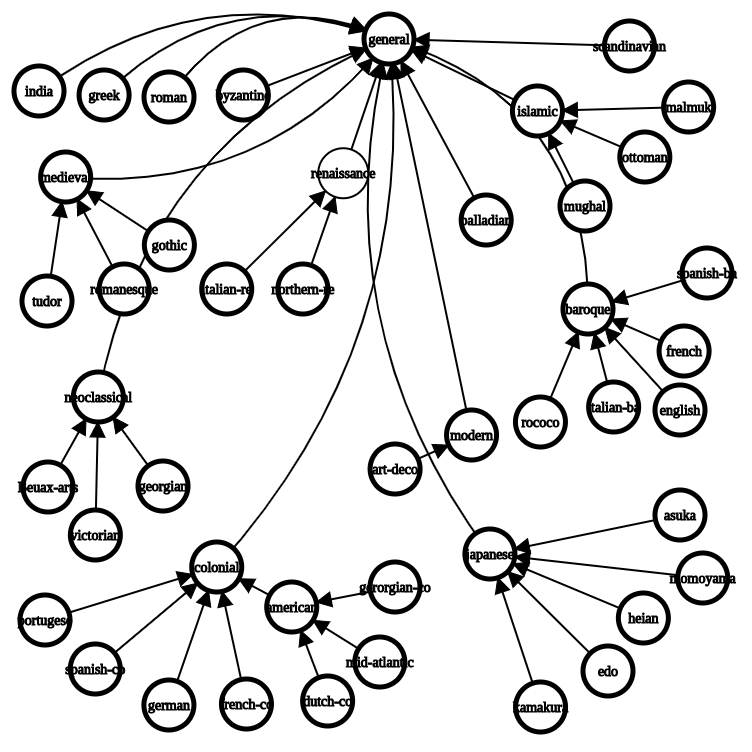
In summary, we have 14 coarse classes: <br>

In [3]:
classes = data[data['class'].notnull()]['class'].drop_duplicates()
classes

0             ancient greek
1             ancient india
3                     roman
4                 byzantine
5                   islamic
8                  medieval
11    medieval scandinavian
12              renaissance
14                  baroque
19                palladian
20             neoclassical
24                   modern
25                 colonial
33                 japanese
Name: class, dtype: object

To train this classifier, we will use Google images, by downloading batches of images given from the search.<br>
For each fine class, we have downloaded about 150-300 images:


Total number of images is 9040


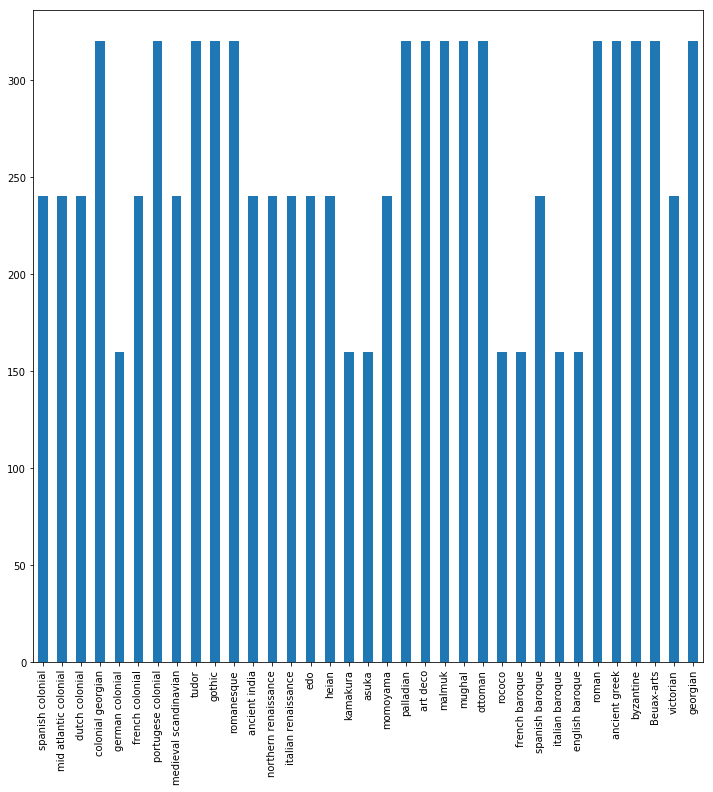

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
counter= pd.Series(name='count',dtype=np.int32)
for (root,dirs,files) in os.walk('../data/urls'):
    for file in files:
        if file=='images.txt':
            src_path = os.path.join(root,file)
            folder_name = os.path.split(root)[-1]
            with open(src_path) as f:
                counter[folder_name] = len(f.read().splitlines())

fig,axes = plt.subplots(1,figsize=(12,12))
counter.plot.bar(ax=axes)
print(f"Total number of images is {counter.sum()}")

### Results
To train our classifier we have chosen to use the fast-ai framework. Since this is a classic image classification task, we knew we wanted to use a CNN network. <br>
Our first attempt at classifying the finest classes was using a resnet34 network that was pretrained on the imagenet dataset. Moreover, to increase our data size we've used data augmentation techniques for images (Horizontal flipping and linear transformations).<br>
After 10 epoches of training, it was clear that the accuracy has converged at around 0.40. <br>
We noticed that one problem we had was the dataset's quality. Since our data was results from google images, it included images of the interior of buildings. For exmaple, our 'french baroque' class had images like
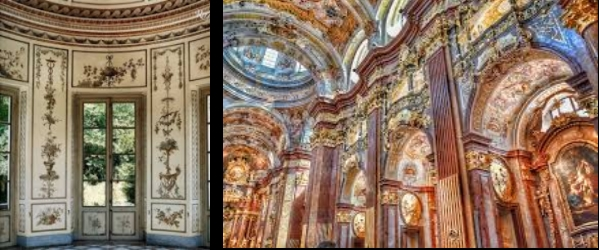<br>

To solve this, we trained a filter for images of building's exterior. This was done in the same way - create a dataset from google images, and train the classifier on a pretrained resnet18 network, which reached a 0.97 accuracy.

In [5]:
from fastai.vision import *
from utils.image_downloader import download_image_dataset
import os

download_image_dataset('exterior_classifer/urls','exterior_classifer/images',8)
tfms = get_transforms(do_flip=True)
data = ImageList.from_folder('exterior_classifer/images/').split_by_rand_pct(0.2).label_from_folder().transform(tfms, size=224).databunch().normalize(imagenet_stats)
exterior_classifier = cnn_learner(data, models.resnet18, metrics=accuracy)
exterior_classifier.load('exterior_classifer')
exterior_classifier.predict(is_test=True)

ModuleNotFoundError: No module named 'fastai'

After we've filtered our data to only contain exterior images, the accuracy of our classification has risen to 0.45. Moreover, when using a resnet50 network, it has risen again to 0.47 accuracy.

In the same manner, we have trained a coarse classifier (which classifies the coarse classes), and it reached 0.6 accuracy.

In [5]:
download_image_dataset('data/urls','data/images',24)
data_archs = get_image_files('data/images/', recurse=True)
def label_from_first_class_folder(path):
  return (path.relative_to('data/images').parts if isinstance(path,Path) else os.path.relpath(path,'data/images').split(os.path.sep))[0]

databunch_archs = ImageDataBunch.from_name_func('data/images/', data_archs, label_from_first_class_folder, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)
learn_archs = cnn_learner(databunch_archs,models.resnet50,metrics=[accuracy])
learn_archs.load('arch_classifier_v3')

NameError: name 'download_image_dataset' is not defined

It is important to note that the fact that our classifiers are not perfect is desirable. When classifying an image we want our classifier "to be confused" - so it will output several possible architectural styles that have influenced a building. <br>
For example, our confusion matrix for the fine classes shows that similar styles are correlated
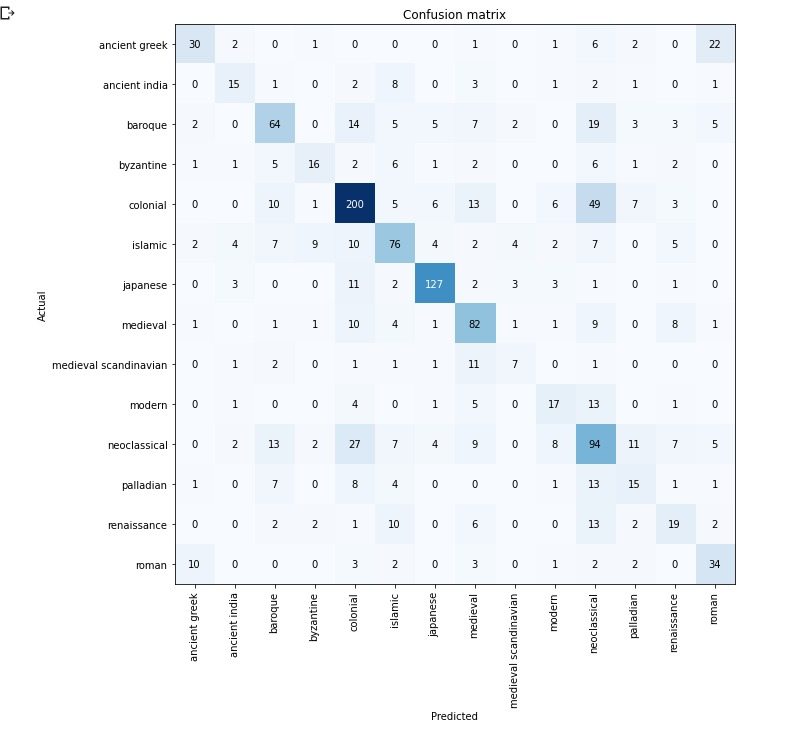

## 2. Finding Specific Buildings to Classify
After training our classifier, we want to gather images of buildings to classify. Most importantly, we want to gather for each image as much metadata as possible. Information like the location of the building, the year it was founded on will be helpful in future analysis. 

### First Idea: Google Street View
The first method that we've considered was Google Street View (GSV). By choosing a random location in the world and classifying it, we will create our map. Using this method we will enjoy the following advantages:
* An "infinite" amount of data
* Knowing the exact location of the building

But this method suffers a major problem. Unfortunately, most buildings are unremarkable. Especially in modern homes, which are influenced by a myriad of styles and limitations that give us little to no information about the many styles that were present at a certain location. <br>
For example, these images below are buildings from South Africa, Spain and Russia, but it is hard to find distinctive features that show the cultural differences
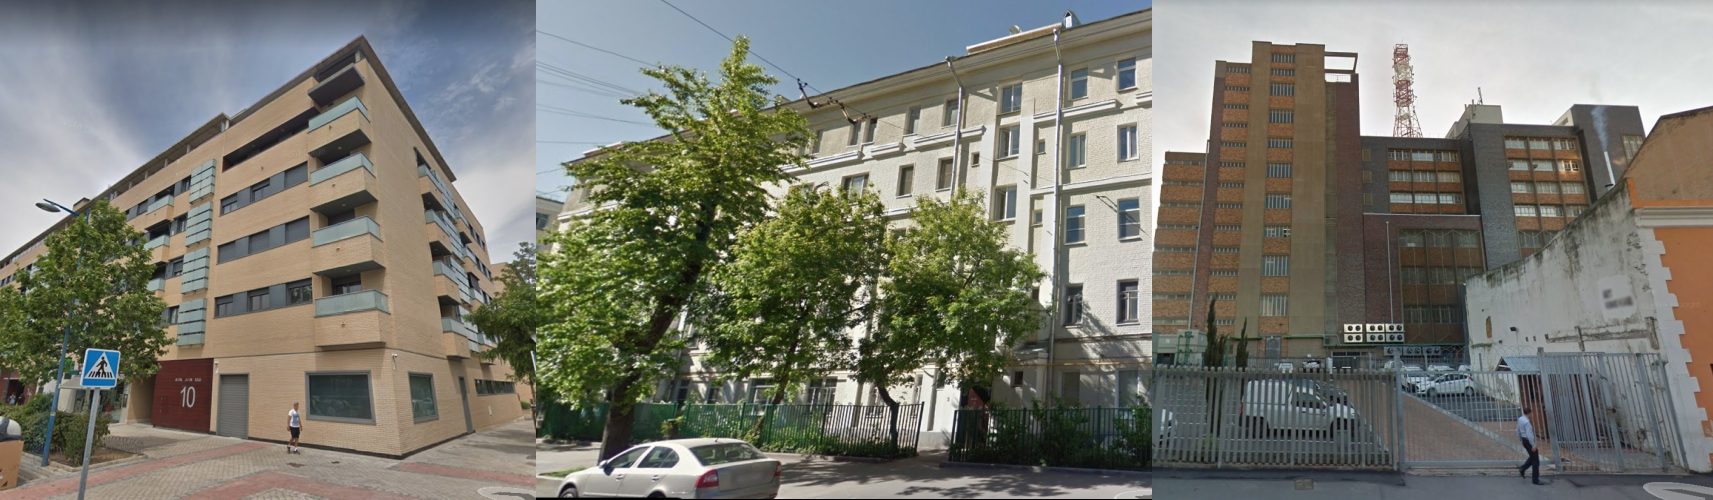

To overcome this issue we would need to scan an unfeasible amount of images, which rendered this method as unsatisfactory.

### Second Idea: Wikipedia
Since we couldn't scan all the buildings in the world, we needed to find a database of buildings that we can easily mine. The one that was chosen was Wikipedia. <br>
Specifically, we found the existence of categories of buildings that we're finished in a given year:
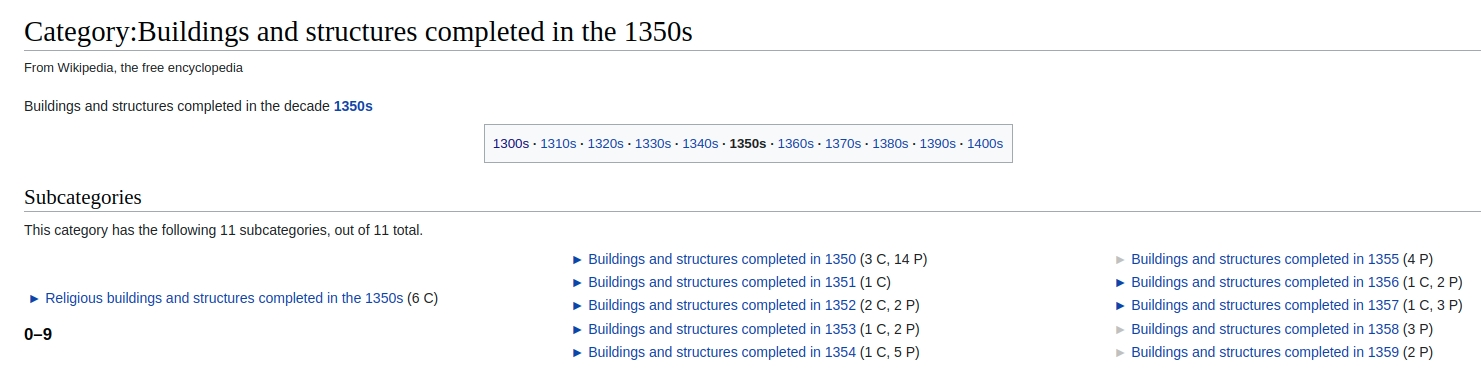

So our process of mining the data was:
1. For each year in a given range (914-1850 was used):
2. Recursivley find all pages in the category "Buildings & Structures ... in {year}"
3. For each page that was found, save its name, year, images that appear in the page. Finally, use a geocoding service to find the location of the building. 

Also, some pages included the architectural style of the building:
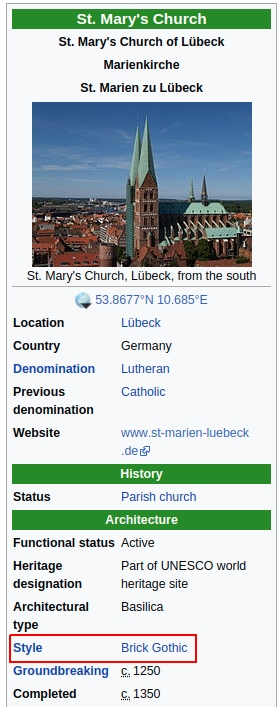
That information was also saved for possible future usage.

Finally, our data looked like this

In [6]:
wiki_data = pd.read_csv('../data/wikipedia/wiki.csv')
print(len(wiki_data))
wiki_data.head(3)

27052


year                                      link  \
0   914             /wiki/Alc%C3%A1zar_of_Seville   
1   944                    /wiki/Al-Askari_Shrine   
2   970  /wiki/All_Saints%27_Church,_Earls_Barton   

                              title  \
0                Alcázar of Seville   
1                  Al-Askari Shrine   
2  All Saints' Church, Earls Barton   

                                          thumbnails  \
0  ['//upload.wikimedia.org/wikipedia/commons/thu...   
1  ['//upload.wikimedia.org/wikipedia/commons/thu...   
2  ['//upload.wikimedia.org/wikipedia/commons/thu...   

                                              images       lat       lng  \
0  ['/wiki/File:Sevilla-2-2_(48040287512).jpg', '...  37.38389  -5.99139   
1  ['/wiki/File:Al-Asakari_Mosque_4.jpg', '/wiki/...  34.19904  43.87353   
2  ['/wiki/File:EarlsBartonChurch.JPG', '/wiki/Fi...  52.26527  -0.75259   

  loc_score        style known_style Unnamed: 10  Unnamed: 11  
0       100          NaN         NaN         NaN          NaN  
1       100          NaN         NaN         NaN          NaN  
2      95.5  Anglo-Saxon         NaN         NaN          NaN

Although this data answers all our needs, its important ot notice that it is biased towards societes that tend to record their history.

# Results

## Style Correlation

Since every building is given a vector of the possibility of each class, we can see the correlation of each pair of classes

In [6]:
wiki_out = pd.read_csv('../data/wikipedia_assesment/wiki_out.csv')
real_classes = []
classes
fields = wiki_out[classes]
corr = fields.corr()
corr.style.background_gradient(cmap='coolwarm')


From these results, we can find some classes that are highly correlated:
1. Roman & Ancient Greek (0.42) - unsurprisingly, these styles are very close. Although it is possible that our classifier is biased, since our dataset of Greek and Roman buildings are images of ruins
2. Baroque & Renaissance (0.268) - this fits reality since they are both in central/west Europe and chronologically close
3. Medieval & Medieval Scandinavian (0.198) - it's in the name.
4. Renaissance & Roman (0.189) - Since the Renaissance was about using old ideas, this is expected. Perhaps the fact the Renaissance & Greek are not correlated (0.065) is suprising.
5. Byzantine & Islamic (0.22) - Both styles are from the area, and are indeed similar. 

Moreover, when we look at classes that are negatively correlated some patterns emerge:
1. The Colonial style is highly separated from the rest of the classes, except Neoclassical. This fits reality since most colonial buildings are found in North America, and not Europe.
2. The Medieval is separated from all "modern" styles: Baeoque, Palladian, Neoclassical, Modern, Colonial are all negatively correlated with Medieval.

We can also look at the average correlation of each style

In [7]:
mean = corr.mean(axis=1)
med = corr.median(axis=1)
r = pd.DataFrame()
r['mean'] = mean
r['median'] = med
r['diff'] = mean - med
r.sort_values(by='mean', ascending=False)

mean    median      diff
renaissance            0.144883  0.110339  0.034544
roman                  0.139824  0.052203  0.087621
ancient greek          0.129682  0.064297  0.065384
byzantine              0.105736  0.028630  0.077106
medieval scandinavian  0.101939  0.066696  0.035243
ancient india          0.097857  0.042303  0.055553
islamic                0.096750  0.042001  0.054748
palladian              0.074900  0.001291  0.073609
baroque                0.073260 -0.030171  0.103431
neoclassical           0.067982  0.046997  0.020984
modern                 0.063801  0.003187  0.060614
japanese               0.063405 -0.004100  0.067506
medieval               0.025945 -0.039369  0.065314
colonial              -0.045022 -0.123266  0.078243

Here we can see clearly that some styles are highly correlated with others:
1. Renaissance is consistently (mean ~= median) highly correlated. Byzantine architecture has similar but weaker results. 
2. Baroque's correlation is high in variability.
3. As expected, Modern architecture is consistently uncorrelated. 

## Center of Mass
We can test our results against our historical knowledge. By finding the center of mass of each style, we can see if it fits the historical reality. 

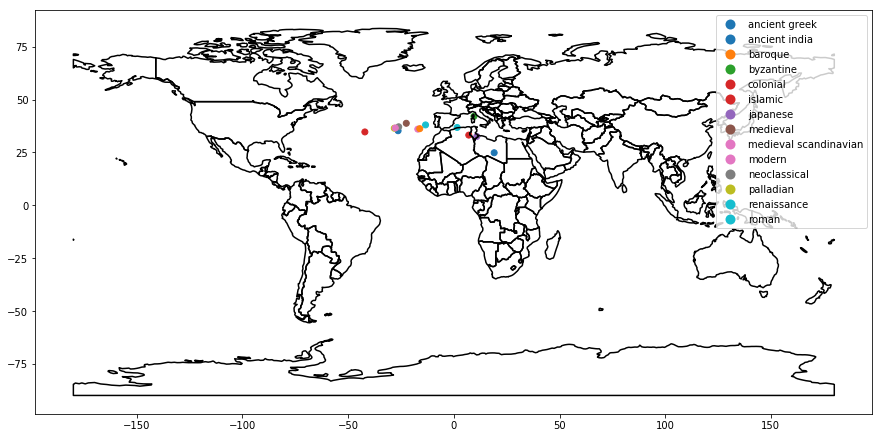

In [8]:
lats = []
lngs = []

for cls in classes:
    class_points = wiki_out[wiki_out['max_class'] == cls]
    lat = class_points['lat'].mean()
    lng = class_points['lng'].mean()
    lats.append(lat)
    lngs.append(lng)
  

centers_of_mass = pd.DataFrame()
centers_of_mass['class'] = classes
centers_of_mass['lat'] = lats
centers_of_mass['lng'] = lngs
centers_of_mass
visualization.plot_points(centers_of_mass)

The results are somewhat helpful. As we'll see in the future, the results are biased towards North America which skews the centers. Moreover the results cluster around the same latitudes. However, we can still discern that the colonial style (which is mostly present in the new world) was indeed in the western hemisphere. 
Reversibly, we can tell that the Indian and Japanese are more eastern. <br>
To make our results more significant, we can look for clusters of styles:

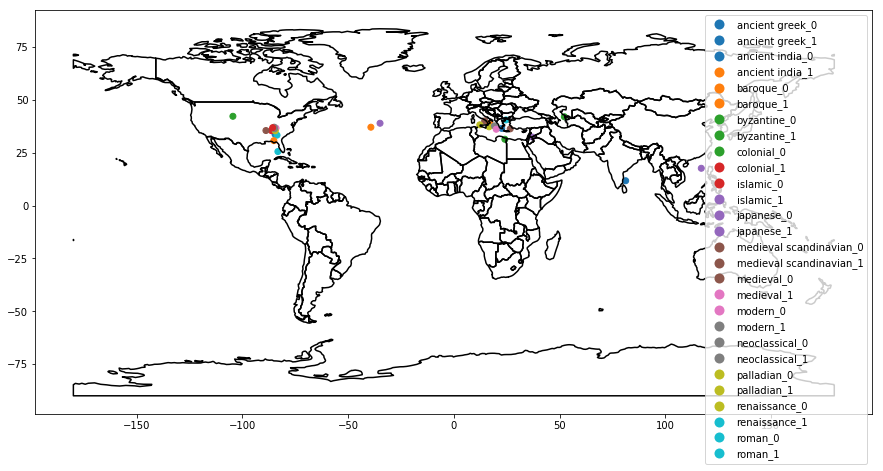

In [9]:
from sklearn.cluster import KMeans

lats = []
lngs = []

centers_of_mass = pd.DataFrame({'class':[], 'lat':[], 'lng':[]})

for cls in classes:
    class_points = wiki_out[wiki_out['max_class'] == cls]
    xy = class_points[['lng', 'lat']]
    kmeans = KMeans(n_clusters=2).fit(xy)
    for index, center in enumerate(kmeans.cluster_centers_):
        centers_of_mass = centers_of_mass.append({'class':f'{cls}_{index}', 'lng':center[0], 'lat':center[1]}, ignore_index=True)
    
visualization.plot_points(centers_of_mass)

If we ignore the clusters in North America, we can see more significant patterns, like one cluster of "Ancient India" being in India, one cluster of "Japanese" being in the far east, but after all we still don't learn a lot from this map. This will be readdressed when using heatmaps.<br>
## Timelines
Another type of data we can look at is histograms of certain styles. Since we have much more data about later years:

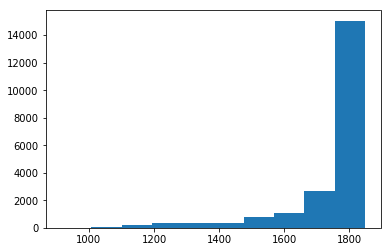

In [10]:
general_hist = plt.hist(wiki_out['year'])

We will normalize our data.

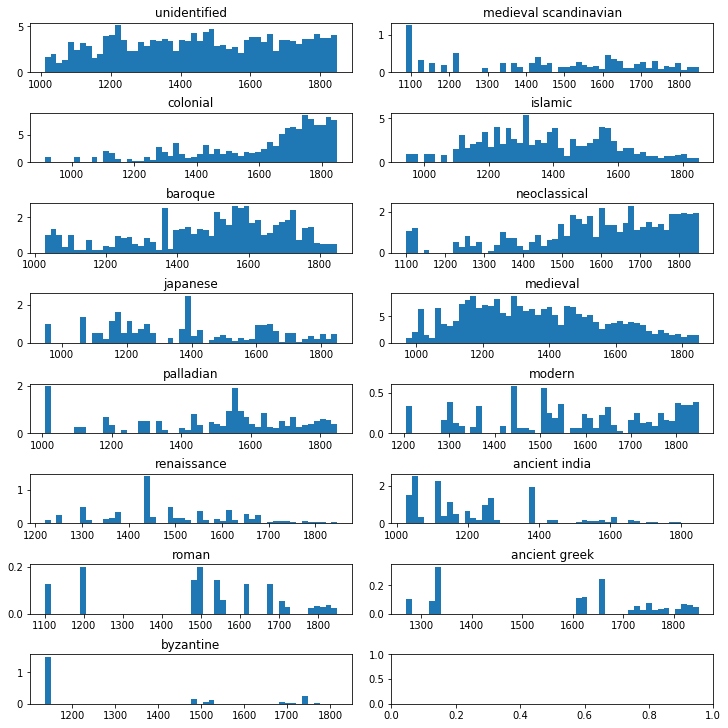

In [11]:
df = wiki_out
_, classes = df['max_class'].factorize()
fig,axis = plt.subplots(8,2,figsize=(10,10),constrained_layout=True)
total_value_counts = df.year.value_counts()
for i,c in enumerate(classes):
    ax = axis[i//2,i%2]
    ax.set_title(c)
    # Normalize count 
    counts = df[df['max_class'] == c]['year'].value_counts()/total_value_counts
    counts = counts[counts.notnull()]
    val, weight = zip(*[(k, v) for k,v in counts.items()])
    ax.hist(val,weights=weight,bins=50)

# Yuval: Any conclusions we get from this???